In [2]:
from fastai.vision.all import *
from moving_mnist.models.phy_original import *
from moving_mnist.models.seq2seq import TeacherForcing
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())
    device = 0

GeForce RTX 2080 Ti


# Train PhyDNet:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [4]:
Path.cwd()

Path('/home/wshuo/workspace/moving_mnist')

In [5]:
DATA_PATH = Path.cwd()/'data'

In [6]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=None)

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

In [ ]:
train_tl = TfmdLists(range(120), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(120), ImageTupleTransform(ds))

In [ ]:
# i=0
# fat_tensor = torch.stack([torch.cat(train_tl[i][0], 0) for i in range(100)])

# m,s = fat_tensor.mean(), fat_tensor.std()

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,#).cuda()
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [ ]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

In [ ]:
dls.show_batch()

In [ ]:
b = dls.one_batch()

In [ ]:
explode_types(b)

## PhyDNet

In [ ]:
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7)) 
convlstm = ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3))   
encoder =  EncoderRNN(phycell, convlstm)

In [ ]:
model = StackUnstack(PhyDNet(encoder, sigmoid=False, moment=True), dim=1).cuda()

A handy callback to include the loss computed inside the model to the target loss

In [15]:
#export
class PHyCallback(Callback):
    def after_pred(self):
        self.learn.pred, self.loss_phy = self.pred
    def after_loss(self):
        self.learn.loss += self.loss_phy

In [16]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, 
                cbs=[TeacherForcing(10), PHyCallback()], opt_func=ranger)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0030199517495930195)

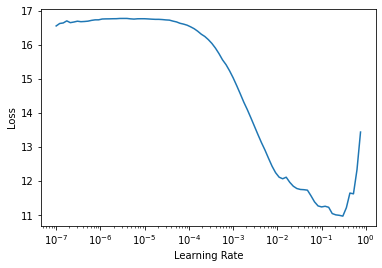

In [17]:
learn.lr_find()

In [18]:
learn.fit_flat_cos(25, 3e-3)

epoch,train_loss,valid_loss,time
0,1.258197,1.339348,02:13
1,1.068752,1.159314,02:13
2,0.977502,0.973215,02:12
3,0.911136,0.906120,02:11
4,0.866704,0.847074,02:12
5,0.817834,0.802413,02:12
6,0.779440,0.782506,02:12
7,0.758171,0.765073,02:12
8,0.741225,0.731223,02:12
9,0.724645,0.736586,02:12


In [19]:
p,t = learn.get_preds(1)

In [20]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [21]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

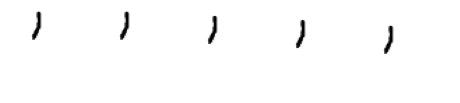

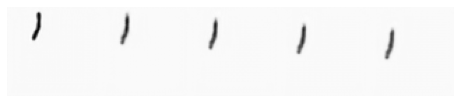

In [27]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k)

In [28]:
learn.save('phydnet')

Path('models/phydnet.pth')